In [ ]:
#load historical  stock data
import yfinance as yf
import pandas as pd
import numpy as np
# Fetch historical stock data (Apple stock)
data = yf.download('AAPL', start='2010-01-01', end='2022-01-01')

# Display the first few rows of the dataset
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455077  6.391278  6.422877  493729600
2010-01-05  6.451467  6.487880  6.417461  6.458088  601904800
2010-01-06  6.348845  6.477044  6.342225  6.451465  552160000
2010-01-07  6.337110  6.379844  6.291067  6.372320  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328684  447610800


In [7]:
#preprocess the data
#normalize the data
from sklearn.preprocessing import MinMaxScaler

# Use only the 'Close' price for prediction
data_close = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

# Display the normalized data
print(data_scaled[:5])


[[0.00385451]
 [0.00391947]
 [0.00332091]
 [0.00325246]
 [0.0034982 ]]


In [13]:
#create data sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    
    return np.array(X), np.array(y)

# Define the sequence length (number of past days used for prediction)
SEQ_LENGTH = 60  # 60 previous days

# Create sequences
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Reshape data for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2961, 60, 1)
y shape: (2961,)


In [14]:
#build and train the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units=1))  # Predicting the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
93/93 [==============================] - 11s 44ms/step - loss: 0.0059
Epoch 2/10
93/93 [==============================] - 4s 43ms/step - loss: 0.0013
Epoch 3/10
93/93 [==============================] - 3s 32ms/step - loss: 9.7921e-04
Epoch 4/10
93/93 [==============================] - 3s 28ms/step - loss: 0.0011
Epoch 5/10
93/93 [==============================] - 3s 28ms/step - loss: 8.9486e-04
Epoch 6/10
93/93 [==============================] - 3s 27ms/step - loss: 8.7759e-04
Epoch 7/10
93/93 [==============================] - 3s 27ms/step - loss: 7.4544e-04
Epoch 8/10
93/93 [==============================] - 3s 27ms/step - loss: 9.0931e-04
Epoch 9/10
93/93 [==============================] - 3s 27ms/step - loss: 9.3004e-04
Epoch 10/10
93/93 [==============================] - 3s 27ms/step - loss: 7.3908e-04


93/93 [==============================] - 1s 9ms/step


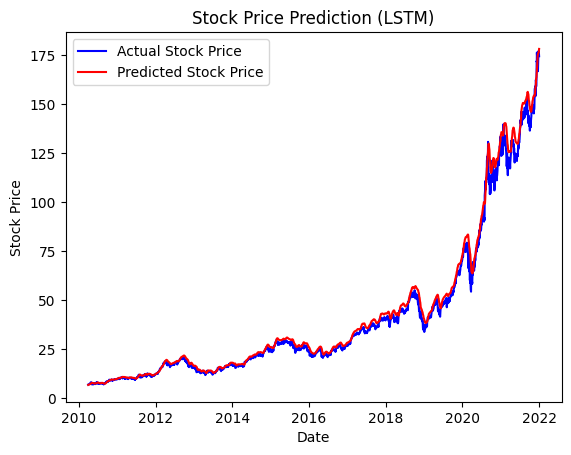

In [15]:
#make predictions and evaluate the model
# Predict stock prices
predicted_stock_price = model.predict(X)

# Inverse transform the predictions to get actual values (back to original scale)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Compare the predicted and actual values
import matplotlib.pyplot as plt

plt.plot(data_close.index[SEQ_LENGTH:], data_close[SEQ_LENGTH:].values, color='blue', label='Actual Stock Price')
plt.plot(data_close.index[SEQ_LENGTH:], predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [16]:
#build  and train the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

# CNN Model: Convert the LSTM data format into a 2D matrix for CNN
X_cnn = X.reshape(X.shape[0], X.shape[1], 1)  # Same format for CNN

# Build the CNN model
cnn_model = Sequential()

# Add convolution layers
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

# Fully connected layer
cnn_model.add(Dense(units=1))  # Predicting the next closing price

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model
cnn_model.fit(X_cnn, y, epochs=10, batch_size=32)


Epoch 1/10
93/93 [==============================] - 1s 3ms/step - loss: 0.0555
Epoch 2/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0504
Epoch 3/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 4/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0500
Epoch 5/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0498
Epoch 6/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0498
Epoch 7/10
93/93 [==============================] - 0s 4ms/step - loss: 0.0496
Epoch 8/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0498
Epoch 9/10
93/93 [==============================] - 0s 4ms/step - loss: 0.0496
Epoch 10/10
93/93 [==============================] - 0s 4ms/step - loss: 0.0495


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
93/93 [==============================] - 8s 43ms/step - loss: 0.0064
Epoch 2/10
93/93 [==============================] - 4s 39ms/step - loss: 0.0011
Epoch 3/10
93/93 [==============================] - 3s 28ms/step - loss: 9.5849e-04
Epoch 4/10
93/93 [==============================] - 2s 27ms/step - loss: 9.0660e-04
Epoch 5/10
93/93 [==============================] - 3s 27ms/step - loss: 9.3006e-04
Epoch 6/10
93/93 [==============================] - 3s 28ms/step - loss: 8.8356e-04
Epoch 7/10
93/93 [==============================] - 3s 27ms/step - loss: 8.5610e-04
Epoch 8/10
93/93 [==============================] - 3s 28ms/step - loss: 8.9117e-04
Epoch 9/10
93/93 [==============================] - 3s 28ms/step - loss: 8.1906e-04
Epoch 10/10
93/93 [==============================] - 3s 27ms/step - loss: 6.5431e-04
Epoch 1/10
93/93 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 2/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 3/1

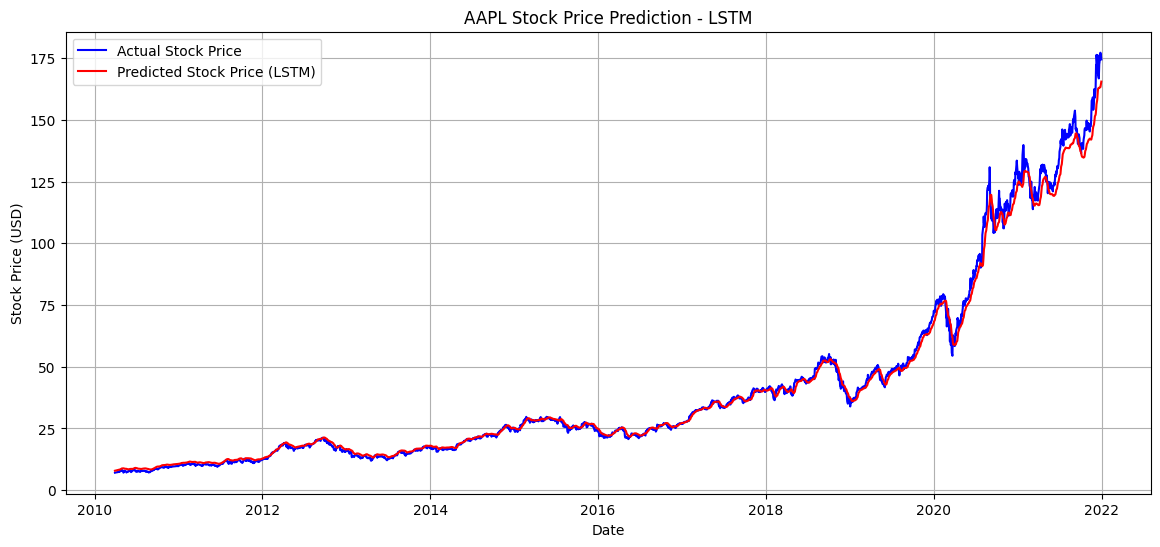

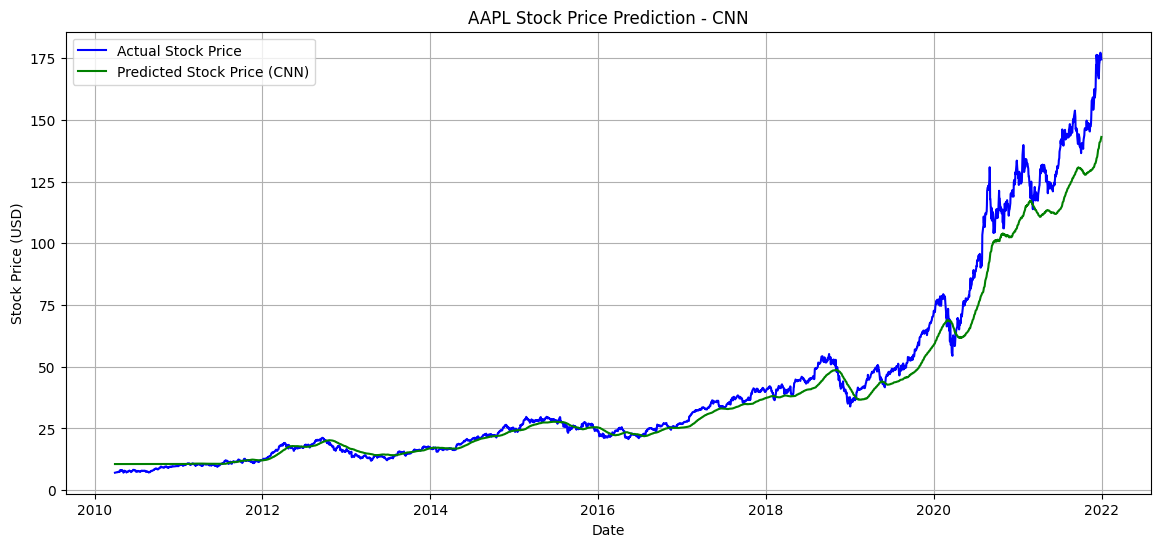

In [17]:
# Data Collection
import yfinance as yf
import pandas as pd

# Download historical stock data
stock_data = yf.download('AAPL', start='2010-01-01', end='2022-01-01')
stock_data = stock_data[['Close']]

# Data Preprocessing (Normalization, Feature Engineering, Sequence Creation)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(stock_data)

# Create Sequences for LSTM and CNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Reshape Data for LSTM
X_lstm = X.reshape(X.shape[0], X.shape[1], 1)

# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm, y, epochs=10, batch_size=32)

# CNN Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_lstm.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(units=1)
])

cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.fit(X_lstm, y, epochs=10, batch_size=32)

# Make Predictions
predicted_lstm_price = lstm_model.predict(X_lstm)
predicted_cnn_price = cnn_model.predict(X_lstm)

# Inverse transform to get actual prices
predicted_lstm_price = scaler.inverse_transform(predicted_lstm_price)
predicted_cnn_price = scaler.inverse_transform(predicted_cnn_price)
actual_prices = scaler.inverse_transform(y)

# Evaluation and Prediction (Plot Results)
import matplotlib.pyplot as plt

# LSTM Plot
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index[SEQ_LENGTH:], actual_prices, color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[SEQ_LENGTH:], predicted_lstm_price, color='red', label='Predicted Stock Price (LSTM)')
plt.title('AAPL Stock Price Prediction - LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# CNN Plot
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index[SEQ_LENGTH:], actual_prices, color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[SEQ_LENGTH:], predicted_cnn_price, color='green', label='Predicted Stock Price (CNN)')
plt.title('AAPL Stock Price Prediction - CNN')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
